## Using Genetic Algorithms to optimize the dataset

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from random import choice
from sklearn import datasets

## Genetic Algorithm

The genetic algorithm to be applied has following characteristics
1. We consider dataset as a set of features. The idea is to change the value of features in such a way such that they align themselves in the manifold in approximately the same way as the original dataset or at least in such a way that the model when trained on this dataset can also perform good on the original dataset.
2. The random dataset generated is **not** generated randomly. Since the problem to be solved will be based on some natural phenomena whose extream values can be measured or known, for example, the blood pressure of a person cannot be higher than say 250. We generate data using a normal distribution between a minimum and a maximum value.
3. For application of genetic algorithm, a bitstring is generated whose length is equivalent to the number of dimension (features) in our dataset (which will be known obviously).
4. For each bit in the bitstring, if the bit == 0, then the feature should not be changed (the column of the matrix won't be changed). Else if bit == 1, then the values of the feature are divided by the mean value of that feature.
5. We find the fitness score of each bitstring by computing the corresponding value of random dataset for the given bitstring and applying the model on it to obtain the accuracy.
6. The genetic algorithm then generates some chromosomes and try to find the best bitstring or chromosome to achieve as much high accuracy as possible.

** The catch here is that the metric applied for changing the feature space is "just dividing by the mean value of feature". New metrics can be used to change dataset in such a way that it aligns the random dataset in some fruitful manner. HERE I TRIED SIMPLE METRICS SUCH AS DIVISION AND ADDITION BY MEAN OF FEATURE VALUES.**

In [2]:
NUM_ITERATIONS = 10
crossover_rate = 0.7
NUM_FEATURES = 30
MUTATION_RATE = 0.001

In [3]:
def get_fitness_score(X, code, orig_data, orig_labels):
    
    """ Get fitness score of the chromosome based on its accuracy"""
        
    bits = np.asarray([int(bit) for bit in list(code)])
    inx = np.where(bits == 1)[0]
    train_data = X
    train_data[:, inx] /= np.mean(train_data,0)[inx]
    
    ## Training the data on rfc
    rfc = RandomForestClassifier()
    rfc.fit(orig_data, orig_labels)
    y = rfc.predict(train_data)
    
    ## Training the rfc on new training data
    rfc = RandomForestClassifier()
    rfc.fit(train_data, y)
    
    ## Accuracy of model is the fitness score
    fitness_score = rfc.score(orig_data, orig_labels)
    return fitness_score

In [4]:
def get_chromosomes(X, orig_data, orig_labels, n_chromo=50, num_features=30):
    """
    Generate a random set of chromosomes
    Each chromosome generated is evaluated for
    its fitness score according to the function
    get_fitness_score()
    
    Returns a dictionary with keys as chromosomes
    and values as their corresponding fitness
    score
    """
    score = {}
    for i in range(1, n_chromo):
        
        code = ''.join([choice(['0','1']) for _ in range(num_features)])
        score[code] = get_fitness_score(X, code, orig_data, orig_labels)

    score['1'*num_features] = get_fitness_score(X, '1'*num_features, orig_data, orig_labels)
    return score

In [5]:
import random
def roulette_wheel_selection(chromosomes):
    """
    Outputs a random chromosome based on fitness score
    Input: A dictionary with keys as bitstring and values
    as fitness score
    """
    max_val = sum(chromosomes.values())
    pick = random.uniform(0, max_val)
    current = 0
    for key, value in chromosomes.items():
        current += value
        if current > pick:
            return key

In [6]:
def cross_over(ch1, ch2, bits):
    """
    Performs crossover between two chromosomes
    Returns two chromosomes which are crossovered
    Input: ch1, ch2 are two chromosomes
    """
    inx = random.randint(0, bits)
    return ch1[:inx]+ch2[inx:], ch2[:inx]+ch1[inx:]

In [7]:
def apply_mutation(ch, mutation_rate):
    """
    Applies mutation to the chromosome according to 
    the mutation rate.
    Returns a mutated chromosome
    """
    mtchr = []
    for gene in ch:
        if random.random() < mutation_rate:
            if gene == '0':
                mtchr.append('1')
            if gene == '1':
                mtchr.append('0')
        else:
            mtchr.append(gene)
    return ''.join(mtchr)

In [8]:
def apply_genetics(random_dataset, orig_data, orig_labels, score, num_chromosomes=50):
    
    """ 
    Apply genetic algorithm
    """
    max_acc = 0
    chromosomes = score
    for _ in range(1, NUM_ITERATIONS+1):
        newPop = []
        while len(newPop) != num_chromosomes:
            ch1 = roulette_wheel_selection(chromosomes)
            ch2 = roulette_wheel_selection(chromosomes)

            if random.random() < crossover_rate:
                ch1, ch2 = cross_over(ch1, ch2, bits=NUM_FEATURES)
            ch1 = apply_mutation(ch1, mutation_rate=MUTATION_RATE)
            ch2 = apply_mutation(ch2, mutation_rate=MUTATION_RATE)
            newPop += [ch1, ch2]
        newFitness = {}
        for chrm in newPop:
            newFitness[chrm] = get_fitness_score(random_dataset, chrm, orig_data, orig_labels)
        if max(newFitness.values()) > max_acc:
            max_acc = max(newFitness.values())
            bitString = newFitness.keys()[np.argmax(newFitness.values())]
        print 'Iteration: {}\n Accuracy: {}'.format(_, max_acc)
        chromosomes = newFitness
    return bitString, max_acc

### Breast Cancer Dataset

In [9]:
data = datasets.load_breast_cancer()

In [10]:
orig_data = data.data
orig_labels = data.target
print orig_data.shape
print orig_labels.shape

(569, 30)
(569,)


In [11]:
from sklearn.preprocessing import StandardScaler
orig_data = StandardScaler().fit_transform(orig_data)
print np.std(orig_data)
print np.mean(orig_data)

1.0
-6.11890932377e-16


In [12]:
def generate_random(orig_data, feature_names, data_size):
    df = {}
    for i in range(len(feature_names)):
        low = np.min(orig_data[:, i])
        high = np.max(orig_data[:, i])
        df[feature_names[i]] = np.random.uniform(low=low, high=high, size=data_size)
    random_dataset = pd.DataFrame(data=df, columns=df.keys())
    return random_dataset

In [13]:
## Generating random dataset
data_size = 1500
random_dataset = generate_random(orig_data, data.feature_names, data_size)
random_dataset.head(3)

,area error,concave points error,mean radius,worst radius,mean concave points,concavity error,worst texture,mean symmetry,compactness error,mean texture,...,mean fractal dimension,mean area,mean concavity,symmetry error,worst perimeter,mean smoothness,fractal dimension error,worst symmetry,worst concavity,texture error
0,8.916459,5.162790,-1.390365,3.379156,2.118508,5.618270,2.529853,1.907197,1.432913,4.439252,...,2.976506,3.744146,4.036558,5.385266,0.026669,4.023211,5.767846,2.106017,4.545343,2.346271
1,8.611103,2.883789,2.746771,-1.715455,0.330918,3.009906,1.295439,4.433510,5.116551,-0.665405,...,4.337728,1.348915,1.874650,6.413361,-0.080304,0.532602,0.522404,-0.115502,1.797526,-0.199133
2,8.940106,5.931816,-0.481406,3.048622,0.285794,3.431186,1.479283,4.031856,1.754287,3.534554,...,2.970304,4.579798,3.908662,1.897077,2.821576,1.705977,2.676246,3.619251,2.740771,3.249181


In [14]:
print np.mean(random_dataset.values)
print np.std(random_dataset.values)

2.1350213418
2.63678762626


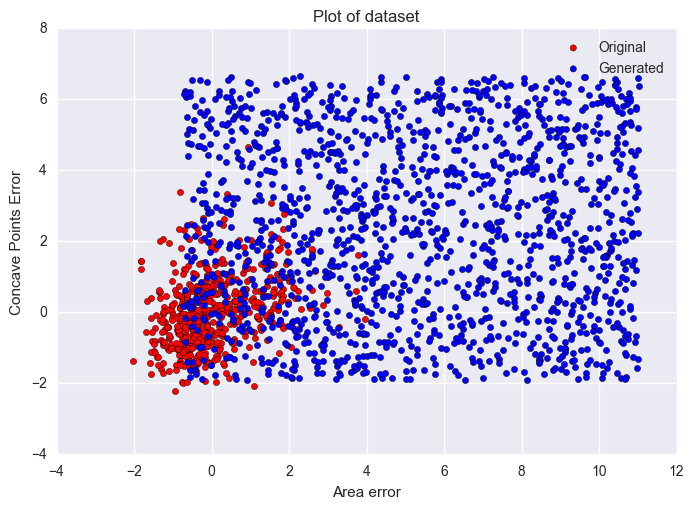

In [15]:
plt.scatter(orig_data[:, 0], orig_data[:, 1],c='r',label='Original')
plt.scatter(random_dataset.values[:, 0], random_dataset.values[:, 1],label="Generated")
plt.xlabel('Area error')
plt.ylabel('Concave Points Error')
plt.title('Plot of dataset')
plt.legend()
plt.show()

In [16]:
rfc = RandomForestClassifier()
rfc.fit(orig_data, orig_labels)
print rfc.score(orig_data, orig_labels)
label = rfc.predict(random_dataset.values)

1.0


In [17]:
rfc = RandomForestClassifier()
rfc.fit(random_dataset.values, label)
print rfc.score(orig_data, orig_labels)

0.488576449912


In [18]:
score = get_chromosomes(random_dataset.values, orig_data, orig_labels)

In [19]:
code = score.keys()[np.argmax(score.values())]
print code, score[code]

100001110100011111011100101100 0.757469244288


In [20]:
for _ in range(10):    
    code = roulette_wheel_selection(score)
    print code, score[code]

011110111100110001000101100110 0.372583479789
111111111000000001001110001101 0.706502636204
100001110100011111011100101100 0.757469244288
000110110111111000111000001010 0.372583479789
000001010111111000111001100101 0.449912126538
000001010111111000111001100101 0.449912126538
100001110100011111011100101100 0.757469244288
010111011010101110011100101001 0.567662565905
111111111111111111111111111111 0.374340949033
100001110100011111011100101100 0.757469244288


In [21]:
bitString, max_acc = apply_genetics(random_dataset.values, orig_data, orig_labels, score)

Iteration: 1
 Accuracy: 0.873462214411
Iteration: 2
 Accuracy: 0.873462214411
Iteration: 3
 Accuracy: 0.873462214411
Iteration: 4
 Accuracy: 0.884007029877
Iteration: 5
 Accuracy: 0.884007029877
Iteration: 6
 Accuracy: 0.894551845343
Iteration: 7
 Accuracy: 0.894551845343
Iteration: 8
 Accuracy: 0.894551845343
Iteration: 9
 Accuracy: 0.894551845343
Iteration: 10
 Accuracy: 0.894551845343


In [22]:
c = []
for _ in range(100):
    c.append(get_fitness_score(random_dataset.values, bitString, orig_data, orig_labels))

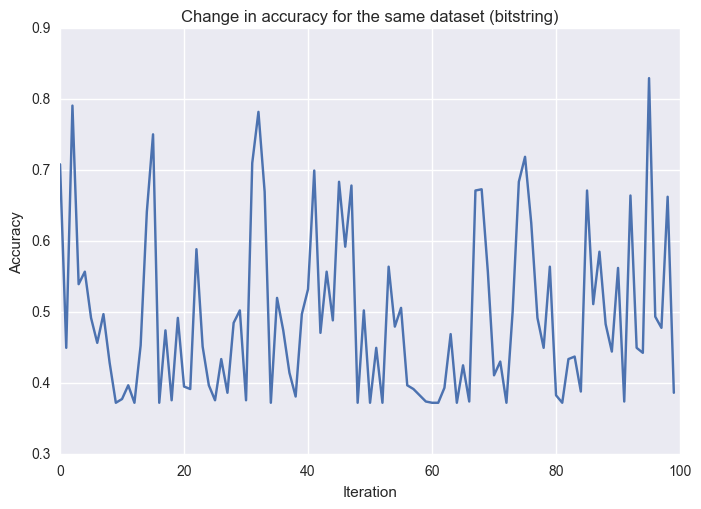

In [23]:
plt.plot(c)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Change in accuracy for the same dataset (bitstring)")

The variability of the model on the same bitstring is quite high. This can be a problem of the short length of the dataset or the model itself. Same procedure with a new dataset is tried below.

### Heart Dataset

In [24]:
data = pd.read_csv('../data/heart.csv')
data.head(2)

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1


In [25]:
orig_labels = data.pop('chd')
data['famhist'] = data['famhist'].map({"Present": 1, "Absent":0})
orig_data = data.values
print orig_data.shape
print orig_labels.shape

(462, 9)
(462,)


In [26]:
orig_data = StandardScaler().fit_transform(orig_data)
print np.mean(orig_data)
print np.std(orig_data)

1.17911132197e-16
1.0


In [27]:
data_size = 1500
random_dataset = generate_random(orig_data, data.columns, data_size)
random_dataset.head(5)

,sbp,alcohol,tobacco,age,typea,ldl,adiposity,famhist,obesity
0,-1.465383,5.066915,3.882948,1.004813,2.440009,3.102036,-2.141079,0.002418,3.831964
1,2.544308,2.418957,4.674664,-1.534735,1.500290,0.363742,1.074940,1.007566,0.317705
2,1.711544,4.090739,0.349988,-0.864426,-2.566861,3.820049,-1.004967,-0.285587,-2.466639
3,-1.793539,2.457972,-0.671317,-1.376482,-3.845493,4.160726,-0.365589,0.852619,-2.242210
4,-0.648470,3.378520,1.847153,-0.320546,-1.004600,4.877774,-0.502062,-0.206021,4.198534


In [28]:
rfc = RandomForestClassifier()
rfc.fit(orig_data, orig_labels)
print rfc.score(orig_data, orig_labels)
label = rfc.predict(random_dataset.values)

0.971861471861


In [29]:
rfc = RandomForestClassifier()
rfc.fit(random_dataset.values, label)
print rfc.score(orig_data, orig_labels)

0.729437229437


In [30]:
score = get_chromosomes(random_dataset.values, orig_data, orig_labels, num_features=9)

In [31]:
code = score.keys()[np.argmax(score.values())]
print code, score[code]

010000001 0.742424242424


In [32]:
bitString, max_acc = apply_genetics(random_dataset.values, orig_data, orig_labels, score)

Iteration: 1
 Accuracy: 0.722943722944
Iteration: 2
 Accuracy: 0.746753246753
Iteration: 3
 Accuracy: 0.746753246753
Iteration: 4
 Accuracy: 0.746753246753
Iteration: 5
 Accuracy: 0.748917748918
Iteration: 6
 Accuracy: 0.75974025974
Iteration: 7
 Accuracy: 0.75974025974
Iteration: 8
 Accuracy: 0.75974025974
Iteration: 9
 Accuracy: 0.75974025974
Iteration: 10
 Accuracy: 0.75974025974


In [33]:
c = []
for _ in range(100):
    c.append(get_fitness_score(random_dataset.values, bitString, orig_data, orig_labels, ))

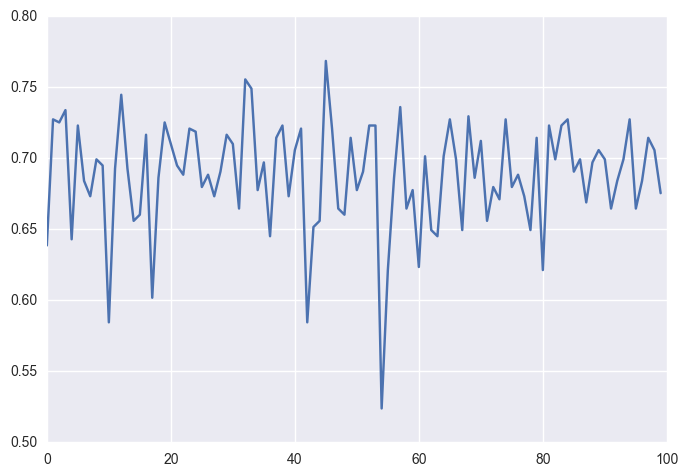

In [34]:
plt.plot(c)
plt.show()

Random Forest seems to produce variable accuracy when trained on the same dataset. The variability in the above case is from 0.5 to 0.75 accuracy. 

**Random Forest produces variability, thus it cannot be implied that any change in the dataset is directly responsible for the higher accuracy. This can be due to the variability of the model also. Hence we need to test our hypothesis on a new classifier (say SVM)**

In [35]:
from sklearn.svm import SVC

In [36]:
def get_fitness_score(X, code, orig_data, orig_labels):
    
    """ Get fitness score of the model based on its accuracy"""
        
    bits = np.asarray([int(bit) for bit in list(code)])
    inx = np.where(bits == 1)[0]
    train_data = X
    train_data[:, inx] /= np.mean(train_data,0)[inx]
    
    ## Training the data on rfc
    svc = SVC()
    svc.fit(orig_data, orig_labels)
    y = svc.predict(train_data)
    
    ## Training the rfc on new training data
    svc = SVC()
    svc.fit(train_data, y)
    
    ## Accuracy of model is the fitness score
    fitness_score = svc.score(orig_data, orig_labels)
    return fitness_score

In [37]:
svc = SVC()
svc.fit(orig_data, orig_labels)
print svc.score(orig_data, orig_labels)
label = svc.predict(random_dataset.values)

0.800865800866


In [38]:
svc = SVC()
svc.fit(random_dataset.values, label)
print svc.score(orig_data, orig_labels)

0.363636363636


In [39]:
score = get_chromosomes(random_dataset.values, orig_data, orig_labels, num_features=9)

In [40]:
code = score.keys()[np.argmax(score.values())]
print code, score[code]

000101010 0.363636363636


In [41]:
bitString, max_acc = apply_genetics(random_dataset.values, orig_data, orig_labels, score)

Iteration: 1
 Accuracy: 0.363636363636
Iteration: 2
 Accuracy: 0.363636363636
Iteration: 3
 Accuracy: 0.363636363636
Iteration: 4
 Accuracy: 0.363636363636
Iteration: 5
 Accuracy: 0.363636363636
Iteration: 6
 Accuracy: 0.363636363636
Iteration: 7
 Accuracy: 0.363636363636
Iteration: 8
 Accuracy: 0.363636363636
Iteration: 9
 Accuracy: 0.363636363636
Iteration: 10
 Accuracy: 0.363636363636


In [42]:
c = []
for _ in range(100):
    c.append(get_fitness_score(random_dataset.values, bitString, orig_data, orig_labels))

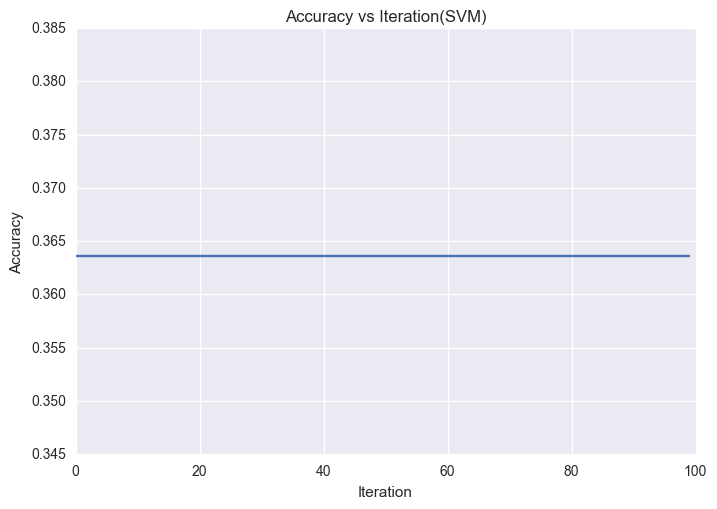

In [43]:
plt.plot(c)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Iteration(SVM)')
plt.show()

Variability in case of SVM is low. The model consistently produces same accuracy. But the model doesn't depend on the bitstring (or change in any single feature of the dataset) and performs same if any one of the feature is changed.

**Variablility is very much dependent on the model**

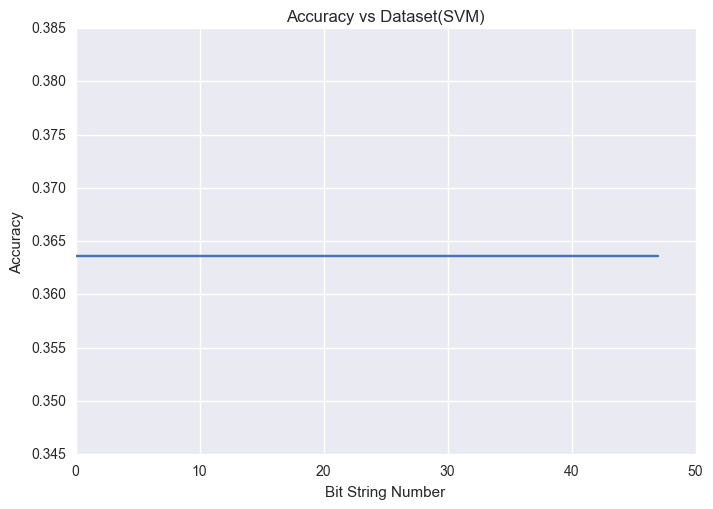

In [44]:
c = []
for bitstring in score.keys():
    c.append(get_fitness_score(random_dataset.values, bitstring, orig_data, orig_labels))
plt.plot(c)
plt.xlabel('Bit String Number')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Dataset(SVM)')
plt.show()

Same accuracy for all of the bistring, implying that SVM behaves similar for all the changes in the dataset. Need to know why?